In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from scipy.signal import find_peaks, medfilt, savgol_filter
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import matplotlib.animation as animation
import matplotlib as mpl
from glob import glob
from copy import copy
from natsort import natsorted
from matplotlib.widgets import Slider
import pandas as pd
import sys
import pickle
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))
sys.path.insert(0, parent_dir)
import matplotlibcolors
plt.style.use(parent_dir + '/matplotlibrc')


%matplotlib widget

In [12]:
def load_files(files):
    s21s = []
    for i, file in enumerate(files):
        freqs, s21 = np.load(file)
        s21s.append(s21)
    return freqs, np.array(s21s)

def smooth_sweep(s21, sw, order):
    smooth_s21 = savgol_filter(s21, sw, order)
    return smooth_s21

def track_tones(s21, locs, limit=5):
    for i, loc in enumerate(locs):
        init_loc = copy(loc)
        prev = s21[loc-1]
        now = s21[loc]
        next = s21[loc+1]
        if next < now:
            while next < now:
                loc += 1
                prev = now
                now = next
                next = s21[loc+1]
        elif next > now:
            while prev < now:
                loc -= 1
                next = now
                now = prev
                prev = s21[loc-1]
        elif next >= now and prev <= now:
            print('At min: ', i)
        else:
            print('No min: ', i)
        if abs(loc - init_loc) <= limit:
            locs[i] = loc
        else:
            print('Too far: ', i)   
    _, unique_indices = np.unique(locs, return_index=True)
    unique_mask = np.zeros(locs.shape, dtype=bool)
    unique_mask[unique_indices] = True
    return locs, unique_mask

def readout_tones(tones, s21s, dark, smoothing_window, smoothing_order):
    smooth_dark = smooth_sweep(dark, smoothing_window, smoothing_order)
    nr_kids = len(tones)
    nr_scans = s21s.shape[0]
    ds21s = np.empty((nr_scans, nr_kids))
    for i, s21 in enumerate(s21s):
        smooth_s21 = smooth_sweep(s21, smoothing_window, smoothing_order)
        for j, tone in enumerate(tones):
            shift = 0
            while s21[tone-shift-1] < s21[tone-shift]:
                shift += 1
            # shift = int(np.argmin(s21[tone-5:tone+1][::-1]))
            dark_min = smooth_dark[tone]
            s21_min = smooth_s21[tone-shift]
            s21_at_dark = s21[tone]
            ds21s[i, j] = (s21_at_dark - dark_min) * (s21_min - dark_min) / -dark_min
    return ds21s

def get_pos(ds21s, mpp):
    nr_kids = ds21s.shape[1]
    pos = np.empty((nr_kids)) # f0, 
    pos[:] = np.nan
    maxproms = np.empty((nr_kids)) # f0, 
    maxproms[:] = np.nan
    secproms = np.empty((nr_kids)) # f0, 
    secproms[:] = np.nan
    doubles = []
    for i in range(nr_kids):
        ds21 = ds21s[:, i]
        y = medfilt(ds21, 3)
        x = np.arange(len(y))
        a, b = np.polyfit(x, y, 1)
        ds21 -= (a*x + b)
        ds21s[:, i] = ds21
        baseline = y - (a*x + b)
        argsort = np.argsort(ds21)
        argmax = argsort[-1]
        secargmax = argsort[-2]
        max = ds21[argmax]
        secmax = ds21[secargmax]
        mean = np.mean(baseline)
        noise = np.std(baseline)
        maxprom = 20*np.log10(max / noise)
        secprom =  20*np.log10(secmax / noise)
        pos[i] = argmax
        maxproms[i] = maxprom
        secproms[i] = secprom
        if secprom >= mpp: 
            if len(doubles):
                if doubles[-1] != i-1:
                    doubles.append(i)
                else:
                    doubles = doubles[:-1]
            else:
                doubles.append(i)
    print('Mean prominence: ', np.mean(maxproms))
    fig, ax = plt.subplot_mosaic('ab', figsize=(4,2))
    hist = ax['a'].hist(pos, bins=np.arange(ds21s.shape[0]+1), facecolor='tab:blue', edgecolor='w')
    ax['b'].axvline(mpp, c='r')
    # ax['a'].axhline(nr_rows, c='r')
    ax['b'].hist(maxproms, bins='auto', alpha=.7)
    ax['b'].hist(secproms, bins='auto', alpha=.7)
    print('total: ', np.sum(~np.isnan(pos)))
    print('nr doubles: ', len(doubles))
    return pos, maxproms, secproms, doubles

def add_kids(added, to_add):
    global rows, cols, maxproms, secproms, maxproms_cols, secproms_cols, f0s, ds21s_rows, ds21s_cols, locs  # Declare global variables

    added = np.array(added, dtype=int)
    to_add = np.array(to_add, dtype=int)
    secargmax_rows = np.argsort(ds21s_rows[:, to_add], axis=0)[-2, :]
    rows = np.insert(rows, to_add, secargmax_rows)
    ds21s_rows = np.insert(ds21s_rows, to_add, ds21s_rows[:, to_add], axis=1)
    secargmax_cols = np.argsort(ds21s_cols[:, to_add], axis=0)[-2, :]
    cols = np.insert(cols, to_add, secargmax_cols)
    ds21s_cols = np.insert(ds21s_cols, to_add, ds21s_cols[:, to_add], axis=1)
    maxproms = np.insert(maxproms, to_add, secproms[to_add])
    secproms = np.insert(secproms, to_add, maxproms[to_add])
    maxproms_cols = np.insert(maxproms_cols, to_add, secproms_cols[to_add])
    secproms_cols = np.insert(secproms_cols, to_add, maxproms_cols[to_add])
    f0s = np.insert(f0s, to_add, f0s[to_add])
    locs = np.insert(locs, to_add, locs[to_add])
    to_add = np.sort(to_add)
    to_add += np.arange(len(to_add))
    for kid in to_add:
        added[added >= kid] += 1
        added = np.hstack((added, kid, kid+1))
    return list(np.sort(added))

def del_kids(added, to_delete):
    global rows, cols, maxproms, secproms, maxproms_cols, secproms_cols, f0s, ds21s_rows, ds21s_cols, locs  # Declare global variables

    to_delete = np.sort(to_delete)
    to_delete = np.array(to_delete, dtype=int)
    added = np.array(added, dtype=int)
    
    rows = np.delete(rows, to_delete)
    cols = np.delete(cols, to_delete)
    maxproms = np.delete(maxproms, to_delete)
    secproms = np.delete(secproms, to_delete)
    maxproms_cols = np.delete(maxproms_cols, to_delete)
    secproms_cols = np.delete(secproms_cols, to_delete)
    f0s = np.delete(f0s, to_delete)
    ds21s_rows = np.delete(ds21s_rows, to_delete, axis=1)
    ds21s_cols = np.delete(ds21s_cols, to_delete, axis=1)
    locs = np.delete(locs, to_delete)
    for kid in to_delete[::-1]:
        if kid in added:
            added = np.delete(added, np.argwhere(added == kid))
        if kid-1 in added: 
            added = np.delete(added, np.argwhere(added == kid-1))
        elif kid+1 in added: 
            added = np.delete(added, np.argwhere(added == kid+1))
        added[added >= kid] -= 1
    return list(added)

def plot_dipshit(s21s, ds21s, pos, kids, steps=[], bw=50):
    global f0s, locs, freqs, avg_s21, smoothing_window, smoothing_order
    fig, ax = plt.subplot_mosaic('ba', figsize=(10,5), constrained_layout=True)
    custom_colors = ['b', 'y', 'g', 'p']

    for kid in kids:
        ds21 = ds21s[:, kid]
        baseline = medfilt(ds21, 3)
        res = f0s[kid]
        loc = locs[kid]
        index = np.arange(loc-bw,loc+bw)
        hit = int(pos[kid])
        ax['b'].axhline(np.mean(baseline), ls='--', lw=1, c='k')
        ax['a'].plot(freqs[index], avg_s21[index], lw=2, label='dark', c='k')
        ax['a'].axvline(res, c='k', ls='--', lw=1)
        ax['a'].plot(freqs[index], smooth_sweep(s21s[hit, index], smoothing_window, smoothing_order), lw=2, label='hit @' + str(hit), c='r')
        ax['b'].axvline(hit, ls='--', lw=2, c='r')
        for i, step in enumerate(steps):
            ax['a'].plot(freqs[index], smooth_sweep(s21s[step, index], smoothing_window, smoothing_order), lw=1, label=str(step), c=custom_colors[i])
            ax['b'].axvline(step, ls='--', lw=1, c=custom_colors[i])
        ax['b'].plot(ds21, lw=2, label=str(kid), c='k')
    ax['b'].legend()
    ax['a'].legend()

def plot_rows(rows, doubles=[], too_close=[], lo=None):    
    global f0s, nr_cols, maxproms
    fig, ax = plt.subplot_mosaic('aaaab', figsize=(14,9), constrained_layout=True, sharey=True)   
    custom_colors = ['r', 'o', 'y', 'g', 'b', 'p']
    custom_cmap = mpl.colors.ListedColormap(custom_colors)
    ax['a'].scatter(f0s, rows, c=maxproms, cmap=custom_cmap)
    cbar = fig.colorbar(ax['a'].collections[0], ax=ax['a'], orientation='vertical', location='left')
    cbar.set_label('Max Prominence')
    for id, row in enumerate(rows):
        ax['a'].annotate(id, (f0s[id], row+.3), fontsize=8, ha='center', va='center', rotation=-45)
    for id in doubles:
        ax['a'].scatter(f0s[id], rows[id], marker='o', facecolor='None', edgecolor='cyan', linewidth=2)
    for id in too_close:
        ax['a'].scatter(f0s[id], rows[id], marker='o', facecolor='None', edgecolor='magenta', linewidth=2)
    min_pos = np.nanmin(rows)
    max_pos = np.nanmax(rows)
    binedges = np.arange(min_pos, max_pos+2, 1)
    ax['a'].set_yticks(binedges)
    hist = ax['a'].grid(True, which='both', linestyle='--', lw=.5)
    if lo:
        ax['a'].axvline(lo, c='k', ls='-', lw=1)
        lo_mask = f0s < lo
        ax['b'].hist([rows[lo_mask], rows[~lo_mask]], bins=binedges-.5, edgecolor='w', orientation='horizontal', label=['< LO', '> LO'], stacked=True)
        ax['b'].axvline(nr_cols/2, c='k', ls='-', lw=1)
    else:
        ax['b'].hist(rows, bins=binedges-.5, edgecolor='w', orientation='horizontal')
    ax['b'].axvline(nr_cols, c='k', ls='-', lw=2)
    ax['b'].legend()

def plot_cols(rows, doubles=[], too_close=[], lo=None):    
    global f0s, nr_rows, maxproms_cols
    fig, ax = plt.subplot_mosaic('b;a;a;a;a', figsize=(9,14), constrained_layout=True, sharex=True)   
    custom_colors = ['r', 'o', 'y', 'g', 'b', 'p']
    custom_cmap = mpl.colors.ListedColormap(custom_colors)
    ax['a'].scatter(rows, f0s, c=maxproms_cols, cmap=custom_cmap)
    cbar = fig.colorbar(ax['a'].collections[0], ax=ax['a'], orientation='horizontal', location='bottom')
    cbar.set_label('Max Prominence')
    for id, col in enumerate(rows):
        ax['a'].annotate(id, (col+.3, f0s[id]), fontsize=8, ha='center', va='center', rotation=-45)
    for id in doubles:
        ax['a'].scatter(rows[id], f0s[id], marker='o', facecolor='None', edgecolor='cyan', linewidth=2)
        # ax['a'].scatter(rows[id+1], f0s[id+1], marker='o', facecolor='None', edgecolor='cyan', linewidth=2)
    for id in too_close:
        ax['a'].scatter(rows[id], f0s[id], marker='o', facecolor='None', edgecolor='magenta', linewidth=2)
    min_pos = np.nanmin(rows)
    max_pos = np.nanmax(rows)
    binedges = np.arange(min_pos, max_pos+2, 1)
    ax['a'].set_xticks(binedges)
    hist = ax['a'].grid(True, which='both', linestyle='--', lw=.5)
    if lo:
        ax['a'].axhline(lo, c='k', ls='-', lw=1)
        lo_mask = f0s < lo
        ax['b'].hist([rows[lo_mask], rows[~lo_mask]], bins=binedges-.5, edgecolor='w', label=['< LO', '> LO'], stacked=True)
        ax['b'].axhline(nr_rows/2, c='k', ls='-', lw=1)
    else:
        ax['b'].hist(rows, bins=binedges-.5, edgecolor='w')
    ax['b'].axhline(nr_rows, c='k', ls='-', lw=2)
    ax['b'].legend()

def map_kids(nans):
    global rows, nr_rows, nr_cols
    row_list = [[] for _ in range(nr_rows)]
    for id, row in enumerate(rows):
        if not np.isnan(row):
            row_list[int(row)].append(int(id))
    map_sorted = np.empty((nr_rows, nr_cols))
    map_sorted[:] = np.nan   
    for i, row in enumerate(row_list):
        map_sorted[i, :len(row)] = row
    for i, j in nans:
        if np.sum(np.isnan(map_sorted[i])) == 0:
            print('discarding highest f0 in row of (%d, %d)' % (i, j))
        map_sorted[i, j+1:] = map_sorted[i, j:-1]
        map_sorted[i, j] = np.nan
    return map_sorted

def roll_map(map, roll):
    for i, row in enumerate(map):
        map[i] = np.roll(row, i*roll)
    return map

def common_mode(x, y, deg):
    coeff = np.polyfit(x, y, deg)
    cmode = np.poly1d(coeff)
    print(cmode)
    return cmode, coeff

def comp_scatter(design, meas, deg): 
    global kid_id_board

    nanmask = np.isnan(meas) + np.isnan(design) 
    centermask = np.zeros_like(meas, dtype=bool)
    ids_center = kid_id_board[1:-1, :-1].flatten()
    centermask[ids_center] = True
    mask = ~nanmask & centermask
    if deg:
        cmode, coeff = common_mode(design[mask], meas[mask], deg)
        design_fit = cmode(design)
    else:
        design_fit = design 
        cmode = None
        coeff = []
    scatter = (meas - design_fit) / design_fit
    return scatter, cmode, coeff

def plot_scatter(deg=1, annotate=False, clim=[]):
    global design, meas, nanmask, kid_id_board, nr_rows, nr_cols, kids

    df_f, cmode, _ = comp_scatter(design, meas, deg)
    df_f_map = df_f[kid_id_board]
    flim = np.array([np.nanmin((design, meas)), np.nanmax((design, meas))])

    fig, ax = plt.subplot_mosaic('abc', figsize=(16, 5), constrained_layout=True)
    ax['a'].scatter(design, design, c='None', edgecolor='tab:blue', label='$\it f_0^{design}$')
    ax['a'].scatter(design, meas, c='None', edgecolor='tab:orange', label='$\it f_0^{meas}$')  
    if deg:
        xfit = np.linspace(flim[0], flim[1])
        yfit = cmode(xfit)
        ax['a'].plot(xfit, yfit, c='k', label='common mode, deg=%d' % (len(cmode.c)-1), ls='--', lw=0.5)
    ax['a'].set_xlabel('$\it f_0^{design}$ $[GHz]$')
    ax['a'].set_ylabel('$\it f_0$ $[GHz]$')
    ax['a'].set_xlim(flim)
    ax['a'].set_ylim(flim)
    ax['a'].legend(loc='upper left')
    if not len(clim):
        clim = [np.amin(df_f[~nanmask]), np.amax(df_f[~nanmask])]
    ax['b'].scatter(design, df_f, c=df_f, vmin=clim[0], vmax=clim[1], label='residual')
    ax['b'].annotate
    ax['b'].set_ylabel('$\it df*/f$')
    ax['b'].set_xlabel('$\it f_0^{design}$ $[GHz]$')
    im = ax['c'].imshow(df_f_map, cmap='viridis', origin='lower', vmin=clim[0], vmax=clim[1])
    if annotate:
        for i, x in enumerate(df_f_map):
            for j, y in enumerate(x):
                if ~np.isnan(y):
                    old_id = kid_id_board[i, j]
                    new_id = kids[i, j]
                    if old_id == new_id:
                        c = 'w'
                    else:
                        c = 'r'
                    ax['c'].text(j, i, '%d' % new_id, ha='center', va='center', fontsize=6, color='w', rotation=45)
    # Major ticks
    ax['c'].set_xticks(np.arange(0, nr_cols, 1)-0.5, minor=False)
    ax['c'].set_yticks(np.arange(0, nr_rows, 1)-0.5, minor=False)
    ax['c'].set_xticks(np.arange(0, nr_cols, 1), minor=True)
    ax['c'].set_yticks(np.arange(0, nr_rows, 1), minor=True)
    # Labels for major ticks
    ax['c'].set_xticklabels(np.arange(0, nr_cols, 1), minor=True, rotation=-90)
    ax['c'].set_yticklabels(np.arange(0, nr_rows, 1), minor=True, rotation=0)
    ax['c'].set_yticklabels([], minor=False)
    ax['c'].set_xticklabels([], minor=False)
    ax['c'].grid(which='major', linestyle='-', linewidth=0.5)
    ax['c'].grid(which='minor', visible=False)
    ax['c'].set_xlabel('$\it x$ $[px]$')
    ax['c'].set_ylabel('$\it y$ $[px]$')
    cbar = fig.colorbar(im, ax=ax['c'])
    _ = cbar.ax.set_ylabel('$\it df*/f$')

    scatter = np.std(df_f[~nanmask])
    pxl_yield = (np.sum(~np.isnan(meas))/(nr_rows*nr_cols))
    print('scatter = %.3f%%' % (scatter*1e2))
    print('yield = %.3f%%' % (pxl_yield*1e2))
    return df_f, df_f_map

def image(ds21s):
    global nr_rows, nr_cols

    nr_scans = ds21s.shape[0]
    maps = np.zeros((nr_rows, nr_cols, nr_scans))
    for nr in range(nr_scans):
        for i, m in enumerate(kids):
            for j, k in enumerate(m):
                if ~np.isnan(k):
                    k = int(k)
                    ds21s[:, k] -= np.amin(ds21s[:, k])
                    ds21s[:, k] /= np.amax(ds21s[:, k])
                    maps[i, j, nr] = ds21s[nr, int(k)]
                else:
                    maps[i, j, nr] = np.nan
    return maps

def plot_image(map, annotate=True):
    global kids
    
    fig, ax = plt.subplots(figsize=(8,8))
    cax = ax.imshow(map, origin='lower', cmap='viridis')
    M, N = map.shape
    if annotate:
        for i, x in enumerate(kids):
            for j, y in enumerate(x):
                    if ~np.isnan(y):
                        new_id = kids[i, j]
                        ax.text(j, i, '%d' % new_id, ha='center', va='center', fontsize=7, color='r')
    # Major ticks
    ax.set_xticks(np.arange(0, N, 1)-0.5, minor=False)
    ax.set_yticks(np.arange(0, N, 1)-0.5, minor=False)
    ax.set_xticks(np.arange(0, M, 1), minor=True)
    ax.set_yticks(np.arange(0, M, 1), minor=True)
    # Labels for major ticks
    ax.set_xticklabels(np.arange(0, N, 1), minor=True, rotation=0)
    ax.set_yticklabels(np.arange(0, M, 1), minor=True, rotation=0)
    ax.set_yticklabels([], minor=False)
    ax.set_xticklabels([], minor=False)
    ax.grid(which='major', linestyle='-', linewidth=0.5)
    ax.grid(which='minor', visible=False)
    return fig, cax

def animate_image(maps, annotate=False, save=None):
    fig, cax = plot_image(maps[:,:, 0], annotate=annotate)
    nr_scans = maps.shape[2]
    def update(frame):
        cax.set_array(maps[:, :, frame])
        return cax,
    ani = animation.FuncAnimation(fig, update, frames=nr_scans, interval=200, blit=True)
    if save:
        ani.save(save, writer='Pillow')
    return ani

def rel_freqs(f0, f1, nr_kids):
    oct = np.log2(f1/f0)
    spacing = 2**(oct/(nr_kids-1))
    powers = np.arange(nr_kids)
    f0s = f0 * (spacing)**powers
    return f0s

def plot_dip(freqs, sweep):
    fig, ax = plt.subplots(figsize=(3,3))
    cax, = ax.plot(freqs, sweep, lw=1, c='b')
    return fig, cax

def plot_dip_with_slider(s21s, kid, bw=50):
    global dark_s21
    loc = locs[kid]
    nr_frames = s21s.shape[0] - 1
    index = np.arange(loc-bw, loc+bw)
    fig, cax = plot_dip(freqs[index], smooth_sweep(dark_s21[index], smoothing_window, smoothing_order))
    ax_slider = fig.add_axes([0.1, 0.01, 0.8, 0.03])  # Slider position
    slider = Slider(ax_slider, 'Frame', -1, nr_frames, valinit=0, valstep=1)

    def update(val):
        frame = int(slider.val)
        sweep = s21s[frame, index]
        cax.set_ydata(smooth_sweep(sweep, smoothing_window, smoothing_order))
        fig.canvas.draw_idle()

    slider.on_changed(update)
    return fig

In [3]:
master = {}
master['design'] = {}
dir  = r"C:\Users\wilbertr\ownCloud2\PhD\PhD\PythonProjects\sonnet\LT402 Design/"
chip = 'LT402_32x32_4-8GHz'
path = dir + chip + '/'
headers = ['f0_pretrim', 'Lc', 'Lf_pretrim', 'w']
keys = ['f0', 'couplers', 'fingers', 'widths']
for i, header in enumerate(headers):
    filepath = path + chip + '_' + header + '.npy'
    data = np.load(filepath)
    master['design'][keys[i]] = data
kid_id_board = np.load( path + chip + '_id.npy')

dir = '.\S21s_20251126_10h46/'
yfiles = natsorted(glob(dir + '*y*.npy'))
xfiles = natsorted(glob(dir + '*x*.npy'))
freqs, s21s_rows = load_files(yfiles)
s21s_cols = load_files(xfiles)[1]
avg_s21 = np.mean(np.vstack((s21s_rows)), axis=0)
_, dark_s21 = np.load(natsorted(glob(dir + '*dark*.npy'))[0])

nr_rows = 32
nr_cols = 32
nr = nr_rows * nr_cols

In [4]:
pretrim = np.load(path + chip + '_Lf_pretrim.npy')[0]
trim = np.load(path + chip + '_Lf.npy')[0]
print(trim, pretrim)
8*97+1+30

745.1213674985219 806.848987437348


807

Total:  1015
Too close, within 0.1 MHz:  21 , ids:  [11, 12, 16, 17, 32, 33, 65, 66, 136, 137, 170, 171, 187, 188, 507, 508, 614, 615, 883, 884, 885]
Overlapping:  3 , ids:  [442, 724, 906]


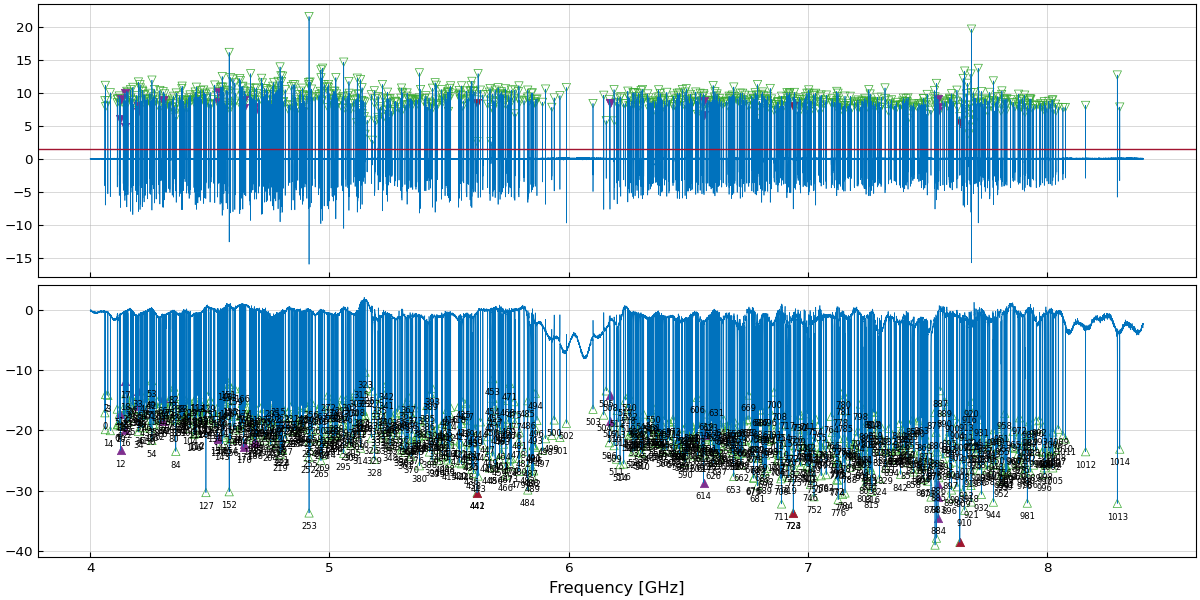

In [5]:
mph = 1.5
min_df = .1
smoothing_window = 2
smoothing_order = 0
smoothed_dark = smooth_sweep(dark_s21, smoothing_window, smoothing_order)
d2s21 = np.diff(smoothed_dark, 2)

init_locs, props = find_peaks(d2s21, height=mph, prominence=mph)
heights = d2s21[init_locs]
init_locs += 1
init_locs, unique_mask = track_tones(smoothed_dark, init_locs)
# unique_mask[414] = 0

init_f0s = freqs[init_locs]
s21_mins = smoothed_dark[init_locs]

# BEGIN:
too_close_mask = np.zeros(init_f0s.shape, dtype=bool)
for i in range(len(init_f0s) - 1):
    if np.abs(init_f0s[i] - init_f0s[i + 1]) < min_df*1e-3 and (unique_mask[i] and unique_mask[i + 1]):
        too_close_mask[i + 1] = True
        too_close_mask[i] = True

        # if s21_mins[i] < s21_mins[i + 1]:
        #     too_close_mask[i + 1] = True
        # else:
        #     too_close_mask[i] = True

fig, ax = plt.subplot_mosaic('a;b', sharex=True, figsize=(12, 6), constrained_layout=True)
ax['a'].plot(freqs[:-2], d2s21, lw=.5)
ax['b'].plot(freqs, smoothed_dark, lw=.5)
ax['a'].axhline(mph, c='r')
mask = ~too_close_mask & unique_mask
ax['a'].scatter(freqs[init_locs[mask]-1], heights[mask], marker='v', c='None', edgecolor='g')
ax['b'].scatter(init_f0s[mask], s21_mins[mask], marker='^', c='None', edgecolor='g')
ax['a'].scatter(freqs[init_locs[too_close_mask]], heights[too_close_mask], marker='v', c='p', edgecolor='p')
ax['b'].scatter(init_f0s[too_close_mask], s21_mins[too_close_mask], marker='^', c='p', edgecolor='p')
ax['a'].scatter(freqs[init_locs[~unique_mask]], heights[~unique_mask], marker='v', c='r', edgecolor='r')
ax['b'].scatter(init_f0s[~unique_mask], s21_mins[~unique_mask], marker='^', c='r', edgecolor='r')
for i, loc in enumerate(init_locs):
    ax['b'].annotate(f'{i}', (init_f0s[i], s21_mins[i]-5), textcoords="offset points", xytext=(0,10), ha='center', fontsize=6)
ax['b'].set_xlabel('Frequency [GHz]')
print('Total: ', len(init_locs))
too_close = np.argwhere(too_close_mask).flatten().tolist()
unique = np.argwhere(~unique_mask).flatten().tolist()
print('Too close, within', min_df, 'MHz: ', len(init_locs[too_close_mask]), ', ids: ', too_close)
print('Overlapping: ', len(init_locs[~unique_mask]), ', ids: ', unique)

Mean prominence:  21.574546193181963
total:  1015
nr doubles:  10
doubles:  [12, 187, 310, 351, 484, 523, 530, 919, 979, 981]
too_close:  [11, 12, 16, 17, 32, 33, 65, 66, 136, 137, 170, 171, 187, 188, 507, 508, 614, 615, 883, 884, 885]
not unique:  [442, 724, 906]
Mean prominence:  23.16323218032579
total:  1015
nr doubles:  7


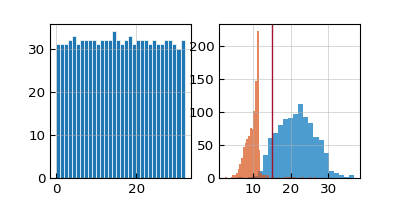

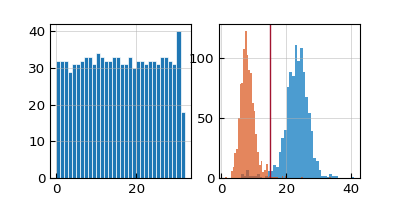

In [13]:
mask = unique_mask
mask = np.ones(init_locs.shape, dtype=bool)
locs = init_locs[mask]
f0s = init_f0s[mask]

ds21s_rows = readout_tones(locs, s21s_rows, dark_s21, smoothing_window, smoothing_order)
ds21s_cols = readout_tones(locs, s21s_cols, dark_s21, smoothing_window, smoothing_order)

mpp = 15
rows, maxproms, secproms, doubles = get_pos(ds21s_rows, mpp)
print('doubles: ', doubles)
print('too_close: ',too_close)
print('not unique: ',unique)
doubles = []
cols, maxproms_cols, secproms_cols, xdoubles = get_pos(ds21s_cols, mpp)

doubles = add_kids([], doubles)
rows[442], cols[442] = 16, 3
rows[723], cols[723] = 14, 0
rows[724], cols[724] = 0, 11
rows[906], cols[906] = 29, 16
# rows[442] = 16
# cols[442] = 3
rows[279] = 19
# rows[906], cols[906] = 29, 16
# delete = [926]
# doubles = del_kids(doubles, delete)
# rows[994] = 30
rows[171], cols[171] = 27, 16
rows[994], cols[994] = 27, 9
rows[995], cols[995] = 30, 7
rows[883], cols[883] = 28, 25
rows[884], cols[884] = 16, 18
rows[885], cols[885] = 6, 22
cols[878] = 22
for i in [1014, 1002, 999, 923, 886, 882, 688, 814, 799, 722, 741, 926, 690]:
    cols[i] = 31
doubles = add_kids(doubles, [746])
rows[746], cols[746] = 26, 9
rows[747], cols[747] = 29, 11
doubles = add_kids(doubles, [443])
rows[443], cols[443] = 31, 13
rows[444], cols[444] = 5, 18
doubles = add_kids(doubles, [380])
rows[380], cols[380] = 10, 29
rows[381], cols[381] = 26, 29
doubles = add_kids(doubles, [84])
cols[84] = cols[85]

# cols[882] = 5

In [ ]:
kid = 83
# 1014, 1002, 999, 923, 886, 882, 688, (884), 814, 799, 722, (746), 741, 926
plot_dipshit(s21s_rows, ds21s_rows, rows, [kid], [])
plot_dipshit(s21s_cols, ds21s_cols, cols, [kid], [])


In [ ]:
kid = 380
plot_dip_with_slider(s21s_rows, kid)
plot_dip_with_slider(s21s_cols, kid)


In [ ]:
plot_rows(rows, doubles, lo=6)

In [ ]:
plot_cols(cols, doubles, lo=6)

In [14]:
nans = [[1, 4],
        [2, 3],
        [24, 13],
        [25, 7],
        [30, 10]]

map = map_kids(nans)
kids = roll_map(np.flip(map, axis=0), 10)

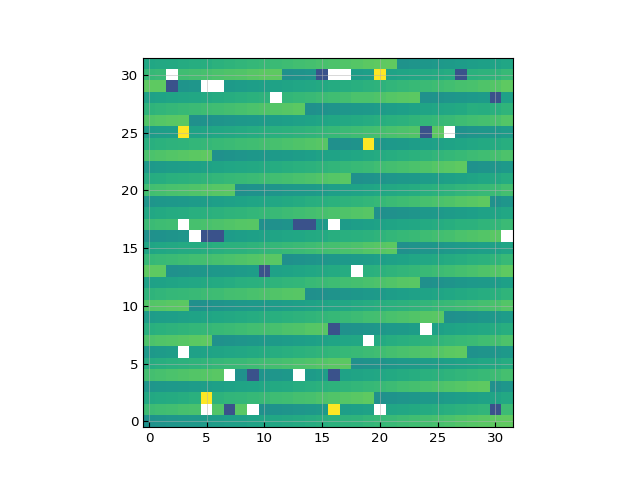

In [15]:
kids2 = np.empty((nr_rows, nr_cols))
kids2[:] = np.nan
for i in range(len(rows)):
    row = int(rows[i])
    col = int(cols[i])
    kid = kids2[row, col]
    if np.isnan(kid):
        kids2[row, col] = i
    else:
        if i in doubles:
            kids2[row, col] = -2000
        else:
            kids2[row, col] = -1000
kids2[np.isnan(kids)] = 2000
kids2 = np.flip(kids2, axis=0)
fig, ax = plt.subplots()
_ = ax.imshow(kids2, cmap='viridis', origin='lower', vmin=-2000, vmax=2000)


Text(0.5, 1.0, 'corrected map')

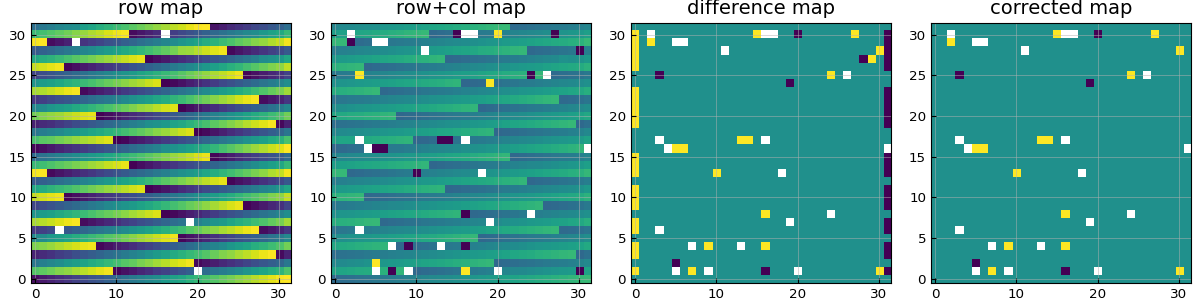

In [16]:
fig, ax = plt.subplot_mosaic('abcd', figsize=(12,3), constrained_layout=True)
diff_kids = kids-kids2
ax['a'].imshow(kids, cmap='viridis', origin='lower')
ax['a'].set_title('row map')
ax['b'].imshow(kids2, cmap='viridis', origin='lower')
ax['b'].set_title('row+col map')
ax['c'].imshow(diff_kids, cmap='viridis', origin='lower', vmin=-1, vmax=1)
ax['c'].set_title('difference map')

swaps = [[27, [28,29]]]
for row, [a,b] in swaps:
    kids[row, a], kids[row, b] = kids[row, b], kids[row, a]

[a, b] = 0, -1
for row in [1, 3, 4, 6, 7, 9, 10, 11, 13, 14, 15, 19, 20, 21, 22, 23, 26, 27, 28, 29, 30]:
    kids[row, a], kids[row, b] = kids[row, b], kids[row, a]

diff_kids = kids-kids2
ax['d'].imshow(diff_kids, cmap='viridis', origin='lower', vmin=-1, vmax=1)
ax['d'].set_title('corrected map')


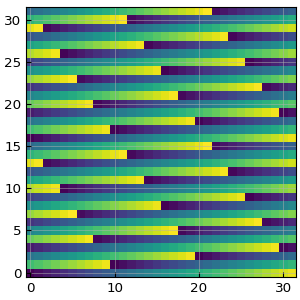

In [17]:
finger_lengths = master['design']['fingers']
design_f0s = master['design']['f0']
coupler_lengths = master['design']['couplers']
fig, ax = plt.subplot_mosaic('a', figsize=(3,3), constrained_layout=True, sharey=True)   
ax['a'].imshow(kid_id_board, cmap='viridis', origin='lower')
master['design']['row'] = np.empty(nr_rows*nr_cols)
master['design']['row'][:] = np.nan
master['design']['col'] = np.empty(nr_rows*nr_cols)
master['design']['col'][:] = np.nan
master['measured'] = {}
master['measured']['f0'] = np.empty(nr_rows*nr_cols)
master['measured']['f0'][:] = np.nan
for i, row in enumerate(kid_id_board):
    for j, idx in enumerate(row):
        master['design']['row'][idx] = i
        master['design']['col'][idx] = j
        meas_idx = kids[i, j]
        if ~np.isnan(meas_idx):
            meas_f = f0s[int(meas_idx)]
            master['measured']['f0'][idx] = meas_f
design = master['design']['f0']
meas = master['measured']['f0']
fingers = master['design']['fingers']
nanmask = np.isnan(meas)
sort_idx = np.argsort(meas[~nanmask])
inverse_sort_idx = np.argsort(sort_idx)



         2
0.01064 x + 0.9748 x - 0.0005062
scatter = 1.172%
yield = 99.512%


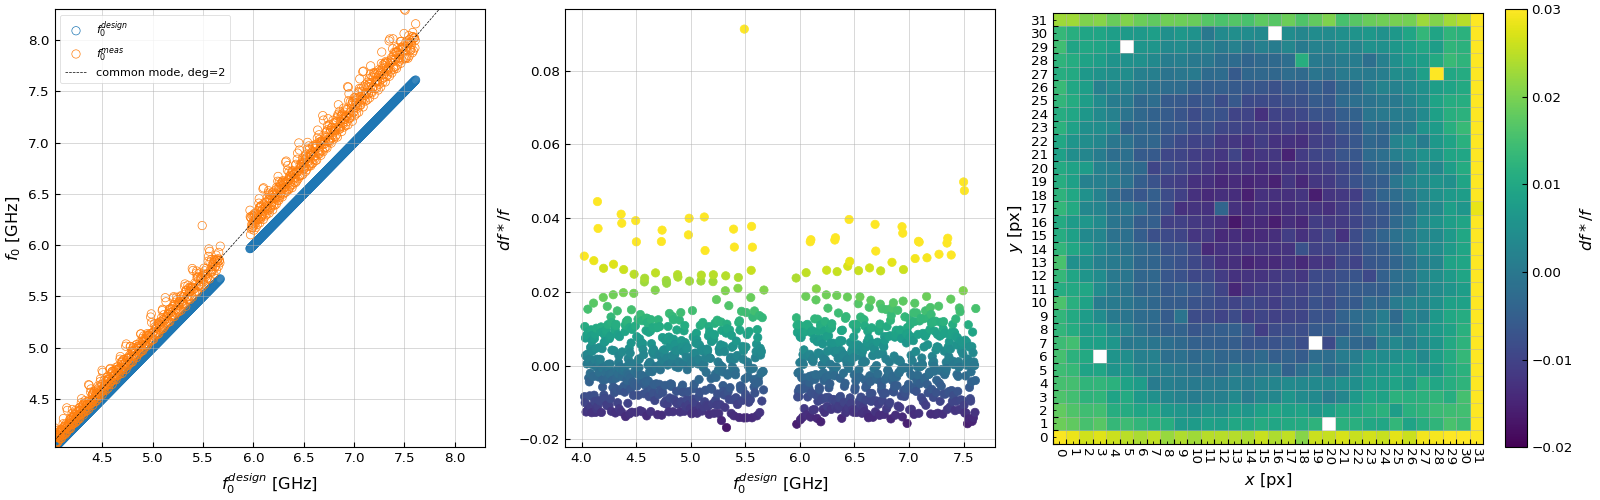

In [18]:
df_f, df_f_map = plot_scatter(2, annotate=False, clim=[-0.02, 0.03])

In [13]:
import numpy as np
from itertools import product

def build_design_matrix(x, y, degree):
    """
    Build polynomial design matrix for 2D total-degree polynomial.
    x, y are 1D arrays of valid (non-NaN) data.
    """
    terms = []
    powers = []
    for i, j in product(range(degree+1), repeat=2):
        if i + j <= degree:
            terms.append((x**i) * (y**j))
            powers.append((i, j))

    return np.vstack(terms).T, powers


def fit_poly2d_nan_safe(X, Y, Z, degree):
    """
    Fit polynomial surface z = f(x,y)
    X, Y, Z are 2D arrays of equal shape, Z may contain NaNs.
    """
    # Flatten the arrays
    x = X.ravel()
    y = Y.ravel()
    z = Z.ravel()

    # Mask out NaN values
    mask = ~np.isnan(z)
    x_valid = x[mask]
    y_valid = y[mask]
    z_valid = z[mask]

    # Build design matrix using only valid points
    M, powers = build_design_matrix(x_valid, y_valid, degree)

    # Least squares solution
    coeffs, *_ = np.linalg.lstsq(M, z_valid, rcond=None)

    return coeffs, powers


def eval_poly2d_on_grid(X, Y, coeffs, powers):
    """
    Evaluate polynomial surface back on a 2D grid.
    NaNs in Z do not matter for evaluation.
    """
    Z_fit = np.zeros_like(X, dtype=float)
    for c, (i, j) in zip(coeffs, powers):
        Z_fit += c * (X**i) * (Y**j)
    return Z_fit

def get_freqs(bw, lo, lo_gap, nr):
    start = lo - bw / 2 + lo_gap / 2
    stop = lo - lo_gap / 2
    nr_under_lo = nr//2 + nr%2
    nr_above_lo = nr - nr_under_lo
    f0a = rel_freqs(start, stop, nr_under_lo)
    f0b = rel_freqs(start + bw/2, stop + bw/2, nr_above_lo)
    if nr % 2 == 0:
        pass
    else:
        print('Warning: uneven number of frequencies (=%d) in band below and above LO' % nr)
    return np.hstack((f0a, f0b))

def quad_sol(f, coeff):
    [a, b, c] = coeff
    return (-b+np.sqrt(b**2 - 4 * a * (c-f))) / (2*a)


def quad(f, coeff):
    [a, b, c] = coeff
    return a*f**2 + b*f + c

         2
0.01064 x + 0.9748 x - 0.0005062
simulated scatter (without edges):  0.0033653592037767026


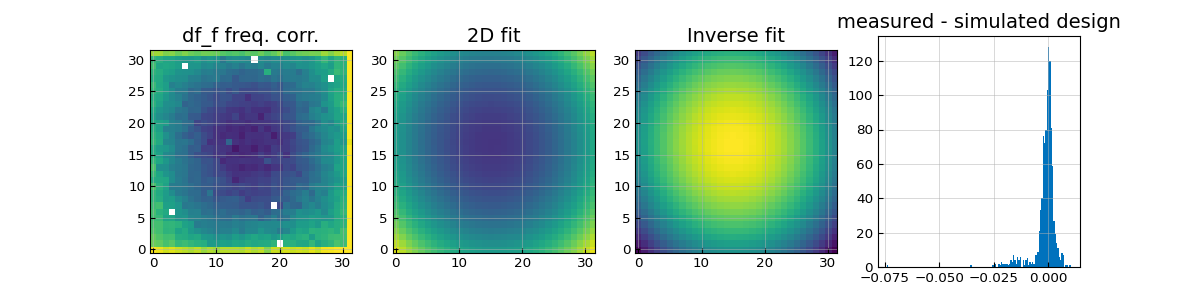

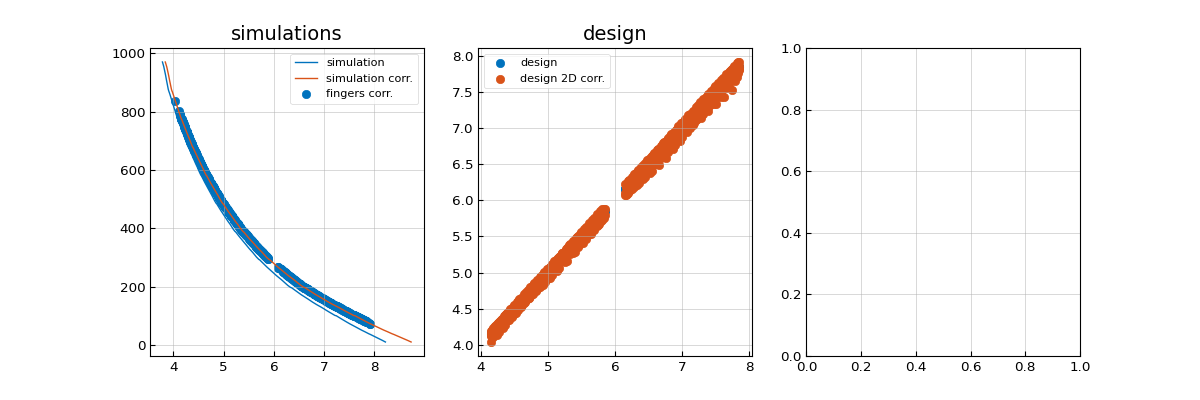

In [22]:
design = master['design']['f0']
meas = master['measured']['f0']

df_f, _, coeff = comp_scatter(design, meas, deg=2)

x = np.arange(31)
y = np.arange(1, 31)
X, Y = np.meshgrid(x, y)
Z = df_f[kid_id_board]
Z[27, 28] = np.nan
Z_center = Z[1:-1, :-1]
degree = 2

coeffs, powers = fit_poly2d_nan_safe(X, Y, Z_center, degree)
X_fit, Y_fit = np.meshgrid(np.arange(32), np.arange(32))
Z_fit = eval_poly2d_on_grid(X_fit, Y_fit, coeffs, powers)

df_name = 'LT402_design_simulations'
dir = r'C:\Users\wilbertr\ownCloud2\PhD\PhD\PythonProjects\sonnet\LT402 Design/'
Lcs_at_Q_design = np.load(dir + df_name + '_Lc.npy')
f0s_at_Q_design = np.load(dir + df_name + '_f0.npy')*1e-9
df = pd.read_pickle(dir + '/' + df_name)
Lfs = np.unique(df['L_fingers'])

f0s_at_Q_design_corr = quad(f0s_at_Q_design, coeff)

new_design = get_freqs(4, 6, 0.3, 1024)
Z_inv = 1 / (Z_fit + 1)
new_design_corr = np.empty(meas.shape)
new_design_corr[kid_id_board.flatten()] = (new_design[kid_id_board] * Z_inv).flatten()
new_design_inv = np.empty(len(new_design))
new_design_inv[kid_id_board.flatten()] = (new_design_corr[kid_id_board] * (Z_fit + 1)).flatten()

corr_Lf = interp1d(f0s_at_Q_design_corr, Lfs)(new_design_corr)
corr_Lc = interp1d(f0s_at_Q_design_corr, Lcs_at_Q_design)(new_design_corr)

fig, ax = plt.subplots(1, 4, figsize=(12, 3))
ax[0].imshow(Z, origin='lower', clim=[-0.02, 0.03])
ax[0].set_title('df_f freq. corr.')
ax[1].imshow(Z_fit, origin='lower', clim=[-0.02, 0.03])
Z_inv = 1/(Z_fit+1)
ax[1].set_title('2D fit')
ax[2].imshow(Z_inv, origin='lower')
ax[2].set_title('Inverse fit')
fm = np.empty(len(design))
fm[kid_id_board.flatten()] = quad((design[kid_id_board] * (Z_fit + 1)).flatten(), coeff)
# fm[kid_id_board.flatten()] = (quad(design, coeff)[kid_id_board] * (Z_fit + 1)).flatten()
df_f_sim = (fm-meas)/meas
ax[3].hist(df_f_sim, bins='auto')
ax[3].set_title('measured - simulated design')
print('simulated scatter (without edges): ', np.nanstd(df_f_sim[kid_id_board][1:-1, :-1]))

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
ax = axes[0]
ax.plot(f0s_at_Q_design, Lfs, label='simulation')
ax.plot(f0s_at_Q_design_corr, Lfs, label='simulation corr.')
ax.scatter(new_design_corr, corr_Lf, label='fingers corr.')
ax.set_title('simulations')
ax.legend()
ax = axes[1]
ax.scatter(new_design, new_design, label='design')
ax.scatter(new_design, new_design_corr, label='design 2D corr.')
# ax.scatter(new_design, new_design_inv, label='design 2D corr.')
ax.set_title('design')
ax.legend()
# np.save('LT402w2_32x32_4-8GHz_Lf.npy', corr_Lf)
# np.save('LT402w2_32x32_4-8GHz_f0.npy', new_design)
# np.save('LT402w2_32x32_4-8GHz_Lc.npy', corr_Lc)

In [20]:
maps = image(ds21s_rows)

In [ ]:
_ = plot_image(maps[:,:, -17], annotate=False)

In [ ]:
anim = animate_image(maps)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(meas[~nanmask][sort_idx], ls='', marker='o', markersize=2)
nr_lower = 505
ax.axvline(nr_lower)
print(nr_lower)

In [ ]:
fig, axes = plt.subplot_mosaic('a;b;c', figsize=(12, 5), sharex=True)
ax = axes['a']
sorted_fs = meas[~nanmask][sort_idx]
lower_f0s = sorted_fs[:nr_lower+1]
upper_f0s = sorted_fs[nr_lower+1:]
ids = np.arange(len(meas))[~nanmask]
lower_ids = ids[:nr_lower+1]
upper_ids = ids[nr_lower+1:]
nr_kids = len(sorted_fs)
nr_upper = nr_kids - nr_lower

nan_ids = np.argwhere(np.isnan(meas)).flatten()
nan_freqs = (meas[nan_ids - 1] + meas[nan_ids + 1])/2
design_nan_freqs = rel_freqs(8.9, 9, len(nan_ids))
nan_diffs = design_nan_freqs - nan_freqs

ax.scatter(ids, sorted_fs, label='measured (sorted)', c='b')
design_lower_f0s = rel_freqs(sorted_fs[5]+0.001, sorted_fs[nr_lower-4]+0.001, nr_lower+1) + 0.003
design_upper_f0s = rel_freqs(sorted_fs[nr_lower+10]+0.01, sorted_fs[-6]+0.04, nr_kids-(nr_lower+1))+0.002
design_total = np.hstack((design_lower_f0s, design_upper_f0s))
diffs = design_total - sorted_fs
ax.scatter(lower_ids, design_total[:nr_lower+1], c='None', edgecolor='o', label='design lower')
ax.scatter(upper_ids, design_total[nr_lower+1:], c='None', edgecolor='y', label='design upper')
ax.axvline(lower_ids[nr_lower], c='k')
not2trim_mask = diffs <= 0
design_total[not2trim_mask] = sorted_fs[not2trim_mask]
ax.scatter(ids[not2trim_mask], design_total[not2trim_mask], c='None', edgecolor='p', lw=2, label='not trimmed')
ax.scatter(nan_ids, nan_freqs, c='k', label='nan KIDs')
ax.legend()
ax = axes['b']
ax.scatter(lower_ids, diffs[:nr_lower+1], c='None', edgecolor='o')
ax.scatter(upper_ids, diffs[nr_lower+1:], c='None', edgecolor='y')
diffs = design_total - sorted_fs
ax.scatter(ids[not2trim_mask], diffs[not2trim_mask], c='None', edgecolor='p', lw=2, label='not trimmed')
ax.axvline(lower_ids[nr_lower], c='k')
ax.scatter(nan_ids, np.zeros(len(nan_ids)), c='k', label='nan KIDs')
ax.axhline(0, c='k')
# ax.set_ylim(-.1, .1)
ax.legend()
ax = axes['c']
ax.scatter(ids[:-1], np.diff(design_total)/design_total[:-1], label='design')
ax.scatter(nan_ids, np.zeros(len(nan_ids)), c='k', label='nan KIDs')

print('df < 0:',  np.sum(diffs<0))
unsorted_design = design_total[inverse_sort_idx]
master['trimdesign'] = {}
master['trimdesign']['f0'] = np.empty(nr_rows*nr_cols)
master['trimdesign']['f0'][:] = np.nan
master['trimdesign']['f0'][~nanmask] = unsorted_design
master['trimdesign']['f0'][nanmask] = design_nan_freqs

In [ ]:
df_name = 'LT402_design_simulations'
dir = r'C:\Users\wilbertr\ownCloud2\PhD\PhD\PythonProjects\sonnet\LT402 Design/'
Lcs_at_Q_design = np.load(dir + df_name + '_Lc.npy')
f0s_at_Q_design = np.load(dir + df_name + '_f0.npy')*1e-9
df = pd.read_pickle(dir + '/' + df_name)
Lfs = np.unique(df['L_fingers'])
fingerslengths = np.linspace(10*1, 10*97, 11, endpoint=True)

centermask = np.zeros((nr_cols*nr_rows), dtype=bool)
ids_center = kid_id_board[1:-1, :-1].flatten()
centermask[ids_center] = True
nanmask = np.isnan(meas_corr)
mask = ~nanmask & centermask

fingers = master['design']['fingers']
trimdesign = master['trimdesign']['f0']
df = trimdesign - meas
trimdesign_corr = design + df
argsort = np.argsort(f0s_at_Q_design)
trimfingers = np.interp(trimdesign_corr, f0s_at_Q_design[argsort], Lfs[argsort], left=10, right=970)
nanlength = np.round(np.nanmin(trimfingers) - 5)
trimfingers[nanmask] = np.arange(nanlength, nanlength - len(nan_ids), -1)
trims = trimfingers - fingers

p = np.polyfit(fingers[mask], meas_corr[mask], 6)
x = np.linspace(10, 970, 100)

fig, axes = plt.subplot_mosaic('abc;dec', figsize=(12, 4), constrained_layout=True)
ax = axes['a']
ax.plot(Lfs, f0s_at_Q_design, 'k--', label='simulations')
ax.scatter(fingers, design, facecolor='b', edgecolor='b', marker='.', label='design')
ax.scatter(fingers[centermask], meas[centermask], facecolor='None', edgecolor='y', label='meas')
# ax.scatter(fingers[~centermask], meas[~centermask], facecolor='None', edgecolor='o', linewidths=2, label='meas (edge)')
ax.scatter(fingers[centermask], meas_corr[centermask], color='o', marker='x', label='meas corr.')
# ax.scatter(fingers[~centermask], meas_corr[~centermask], facecolor='None', edgecolor='y', linewidths=2, label='meas corr. (edge)')
# ax.scatter(fingers[centermask], trimdesign[centermask], facecolor='None', edgecolor='g', marker='s', label='trimdesign')
# ax.scatter(fingers[~centermask], trimdesign[~centermask], facecolor='None', edgecolor='p', linewidths=2, label='trimdesign (edge)')
# ax.scatter(fingers[centermask], trimdesign_corr[centermask], facecolor='g', edgecolor='g', label='trimdesign corr.')
# ax.scatter(fingers[~centermask], trimdesign_corr[~centermask], facecolor='None', edgecolor='g', linewidths=2, label='trimdesign corr. (edge)')
# for fingerslength in fingerslengths:
#     ax.axvline(fingerslength, c='k', ls='--', lw=0.5)
# ax.plot(fingers, np.polyval(p, fingers), 'k-', label='polyfit (center)')
# ax.scatter(trimfingers[centermask], trimdesign[centermask], facecolor='gray', edgecolor='None', linewidths=2, label='trimdesign (interp)')
# ax.scatter(trimfingers[~centermask], trimdesign[~centermask], facecolor='None', edgecolor='gray', linewidths=2, label='trimdesign (interp) (edge)')
ax.set_xlabel('Finger length [um]')
ax.set_ylabel('Frequency [GHz]')
ax.legend()
ax = axes['b']
ax.plot(np.arange(1024), trims, 'o ')
ax = axes['d']
ax.plot(np.sort(trimdesign))
ax = axes['c']
ax.imshow(trims[kid_id_board], origin='lower', cmap='viridis')
ax = axes['e']
ax.plot(np.diff(design)/design[:-1], 'o-', label='design')


master['trimdesign']['fingers'] = trimfingers


In [ ]:
fig, axes = plt.subplot_mosaic('a;b;c', figsize=(18.5/3*2/2.54, 10/2.54), sharey=False, constrained_layout=True)
ax = axes['a']
# ax.scatter(np.arange(len(design)), design, facecolor='b', edgecolor='b', marker='.', label='$f_{0,d}$')
ax.scatter(ids, sorted_fs, facecolor='None', edgecolor='y', label='$F^{meas}_{0}$ sorted', lw=2)
ax.scatter(ids, design_total, facecolor='None', edgecolor='g', marker='s', label='$F^{trim}_{0}$ sorted', lw=2)
ax.set_xticklabels([])
ax.set_ylabel('F [GHz]')
ax.set_xlabel('#')
ax.legend()
ax.set_ylim(4.25, 4.35)
ax.set_xlim(40, 80)
ax = axes['b']
ax.plot(Lfs, f0s_at_Q_design, 'k--', label='design')
# ax.scatter(fingers, design, facecolor='b', edgecolor='b', marker='.', label='$F^{design}_{0}$', lw=2)
ax.scatter(fingers[centermask], meas[centermask], facecolor='None', edgecolor='y', label='$F^{meas}_{0}$', lw=2)
ax.scatter(fingers[centermask], meas_corr[centermask], color='o', marker='x', label='$F^{meas}_{0}$ corrected', lw=2)
# ax.scatter(trimfingers, trimdesign, facecolor='None', edgecolor='g', marker='s', label='$F^{trim}_{0}$', lw=2)
ax.set_ylim(4.25, 4.35)
ax.set_xlim(650, 750)
ax.set_xlabel('L [um]')
ax.set_ylabel('F [GHz]')

# ax.set_xlim(600,775)
ax.legend()
ax = axes['c']
ax.plot(Lfs, f0s_at_Q_design, 'k--', label='design')
# ax.scatter(fingers, design, facecolor='b', edgecolor='b', marker='.', label='$F^{design}_{0}$', lw=2)
ax.scatter(fingers, meas, facecolor='None', edgecolor='y', label='$F^{meas}_{0}$', lw=2)
# ax.scatter(fingers, meas_corr, color='o', marker='x', label='$F^{meas}_{0}$ corrected', lw=2)
ax.scatter(trimfingers, trimdesign, facecolor='None', edgecolor='g', marker='s', label='$F^{trim}_{0}$', lw=2)
ax.set_ylim(4.25, 4.35)
ax.set_xlim(650, 750)
ax.set_xlabel('L [um]')
ax.set_ylabel('F [GHz]')
# ax.set_xlim(600,775)
ax.legend()

In [ ]:
np.sort(trimfingers)[:10]

In [ ]:
trims[kid_id_board][0,15] / 2

In [36]:
# np.save(path + chip + '_Lf_trim_chip4.npy', master['trimdesign']['fingers'])
# np.save(path + chip + '_f0_trim_chip4.npy', master['trimdesign']['f0'])
# with open('LT402chip4_master.pkl', 'wb') as f:
#     pickle.dump(master, f)

In [ ]:
fingers = master['design']['fingers']
ids  = np.arange(nr)
trim_design = master['trimdesign']['f0']

fig, axes = plt.subplot_mosaic('aabbee;ccddee', figsize=(15,5), constrained_layout=True)
ax = axes['a']
ax.scatter(design, fingers, label='design f')
ax.scatter(meas, fingers, label='meas f')
# ax.scatter(trim_design, fingers, label='nibble f')
ax.set_ylabel('finger length [um]')
ax.set_xlabel('frequency [GHz]')

def poly(x, a, b, c, d, e, f):
    return a*x**5 + b*x**4 + c*x**3+d*x**2+e*x+f

center_mask = np.zeros((nr_cols*nr_rows), dtype=bool)
ids_center = kid_id_board[1:-1, :-1].flatten()
center_mask[ids_center] = True
fitmask = ~nanmask
popt, pcov = curve_fit(poly, meas[fitmask], fingers[fitmask])
fit_fingers = poly(meas, *popt)   
fit_fingers[nanmask] = poly(nan_freqs, *popt)
new_fingers = poly(trim_design, *popt)
nibble_fingers = new_fingers+(fingers-fit_fingers)
trims = nibble_fingers - fingers

x = np.linspace(np.nanmin(meas), np.nanmax(meas))
ax.plot(x, poly(x, *popt), c='k', lw=1, label='fit')	
# ax.scatter(trim_design, nibble_fingers, c='r', lw=1, label='nibble f+trim')
ax.legend()
ax = axes['b']
ax.scatter(ids, trims)
ax.set_xlabel('kids')
ax.set_ylabel('trim [um]')
ax.axhline(0, c='r')
print('minimum trim = %.3f um' % np.nanmax(trims[trims<0]))
print('maximum trim = %.3f um' % np.nanmin(trims))

ax = axes['c']
ax.scatter(design, design, label='original design')
ax.scatter(design, meas, label='measured')
ax.scatter(design, trim_design, label='nibble design')
ax.set_ylabel('freqency [GHz]')
ax.set_xlabel('design frequency [GHz]')
ax.legend()
ax = axes['d']
secax = ax.twinx()
df = (trim_design[~nanmask][sort_idx][1:]-trim_design[~nanmask][sort_idx][:-1])
df_f = df / trim_design[~nanmask][sort_idx][:-1]
lo = np.argmax(df)
lo_mask = np.ones(len(df), dtype=bool)
lo_mask[lo] = 0
ax.plot(df[lo_mask]*1e3, label='abs. spacing df')
secax.plot(df_f[lo_mask]*1e4, c='o', label='rel. spacing df/f')
ax.set_ylabel('df [MHz]')
secax.set_ylabel('df/f $\\times 10^4 $')
ax.set_xlabel('kids')
ax.legend()
secax.legend()
ax = axes['e']
ax.imshow(trims[kid_id_board], origin='lower')
master['trimdesign']['fingers'] = nibble_fingers
print('Frequenty range: %.2f-%.2f GHz' % (np.nanmin(trim_design), np.nanmax(trim_design)))
print('LO gap: %d MHz at %.2f GHz' % (np.nanmax(df)*1e3, (trim_design[np.argmax(df)]+trim_design[np.argmax(df)+1])/2))
print('%d pixels >= 0: ' % (np.sum(trims >= 0)), np.argwhere(trims >= 0).flatten())

In [ ]:
with open('../LT402chip6/LT402chip6_master.pkl', 'rb') as f:
    master = pickle.load(f)
fig, ax = plt.subplots()
ax.plot(design, nibble_fingers-trimfingers, c='k', ls='--')

fm = master['trimmeasured']['f0']
fd = master['trimdesign']['f0']
df_f, _ = comp_scatter(fd, fm, 2)
secax = ax.twinx()

secax.plot(fd, df_f, 'o ', alpha=0.5)
secax.set_ylim(-0.001, 0.001)
ax.set_ylim(-4, 6)

# for fingerslength in fingerslengths:
#     ax.axvline(fingerslength, c='k', ls='--', lw=0.5)

In [69]:
# np.save(path + chip + '_Lf_trim_chip6.npy', master['trimdesign']['fingers'])
# with open('LT402chip6_masterv2.pkl', 'wb') as f:
#     pickle.dump(master, f)
    

In [59]:
from scipy.optimize import fsolve


def find_roots(f1s, l1s, l2s):
    f2s = np.empty(f1s.shape)
    for i in range(len(f1s)):
        f1 = f1s[i]
        l1 = l1s[i]
        l2 = l2s[i]
        if np.isnan(f1) or np.isnan(l1) or np.isnan(l2):
            f2s[i] = np.nan
        else:
            y1 = poly(f1, *popt)
            dl = l1 - y1
            y2  = l2 - dl
            f2 = fsolve(lambda x: poly(x, *popt) - y2, 5)[0]
            f2s[i] = f2
    return np.array(f2s)

In [ ]:
l2s = np.load(path + chip + '_trim_Lf_chip6.npy')
with open(path + 'LT402chip6_master.pkl', 'rb') as f:
    m = pickle.load(f)
l1s = m['trimdesign']['fingers']
f1s = m['trimdesign']['f0']
f2s = find_roots(f1s, l1s, l2s)

fig, ax = plt.subplot_mosaic('abcd')
ids = np.arange(len(f1s))
ax['a'].scatter(ids, l1s, label='master')
ax['a'].scatter(ids, l2s, label='masker')
ax['a'].legend()
ax['b'].scatter(ids, l1s-l2s)
ax['c'].scatter(ids, f2s-f1s)
sorted_f2s = np.sort(f2s[~np.isnan(f2s)])
ax['d'].plot((sorted_f2s[1:]-sorted_f2s[:-1])/sorted_f2s[:-1])
m['trimdesign masker'] = {}
m['trimdesign masker']['fingers'] = l2s
m['trimdesign masker']['f0'] = f2s

In [ ]:
# with open('LT402chip6_master.pkl', 'wb') as f:
#     pickle.dump(m, f)

In [69]:
np.savetxt('LT402_32x32_4-8GHz_f0_trim_chip6.npy', f2s)